In [2]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from itertools import combinations, product
from statistics import mean

First, we will read in and clean the data. 

In [3]:
def clean_data(penguins):
    """
    Cleans the penguins data. 
    """
    # Dropping unneeded columns and rows
    penguins = penguins.drop(['studyName', 'Sample Number', 'Individual ID', 'Date Egg', 'Comments', 'Region'], axis = 1)
    penguins = penguins.dropna()

    # Recoding and cleaning Sex column
    recode1 = {"MALE"  : 0, "FEMALE" : 1, "." : 2}
    penguins["Sex"] = penguins["Sex"].map(recode1)
    penguins = penguins[penguins['Sex'] != 2]

    # Recoding Island column
    recode2 = {'Biscoe'  : 0, 'Dream' : 1, 'Torgersen'  : 3}
    penguins["Island"] = penguins["Island"].map(recode2)
    
    # Cleaning species column
    penguins["Species"] = penguins["Species"].str.split().str.get(0)
    
    le = preprocessing.LabelEncoder()
    #stage
    penguins['Stage'] = le.fit_transform(penguins['Stage'])
    #clutch competition
    penguins['Clutch Completion'] = le.fit_transform(penguins['Clutch Completion'])

    
    return penguins

In [4]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)
myData = penguins
penguins = clean_data(penguins)


In [5]:
penguins.head()

,Species,Island,Stage,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
1,Adelie,3,0,1,39.5,17.4,186.0,3800.0,1,8.94956,-24.69454
2,Adelie,3,0,1,40.3,18.0,195.0,3250.0,1,8.36821,-25.33302
4,Adelie,3,0,1,36.7,19.3,193.0,3450.0,1,8.76651,-25.32426
5,Adelie,3,0,1,39.3,20.6,190.0,3650.0,0,8.66496,-25.29805
6,Adelie,3,0,0,38.9,17.8,181.0,3625.0,1,9.18718,-25.21799


# Exploratory Figures and Table
In this next section, we are going to use tables and figures to get a first look into seeing what columns we might want to use to train our model.

## Figure 1

Text(0.5, 0.98, 'Culmen Depth vs Culmen Length')

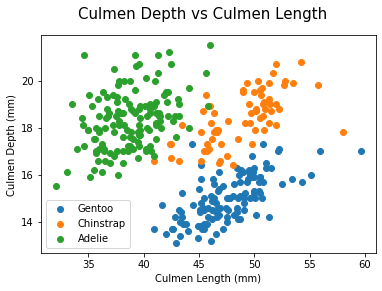

In [6]:
fig, ax = plt.subplots(1)
species = set(penguins['Species'])

for s in species:
    i = penguins[penguins['Species'] == s]
    ax.scatter(i['Culmen Length (mm)'], i['Culmen Depth (mm)'], label = s)
    
ax.legend()

ax.set(xlabel = 'Culmen Length (mm)',
       ylabel = 'Culmen Depth (mm)')

fig.suptitle('Culmen Depth vs Culmen Length', fontsize=15)

In [11]:
species
x = penguins[penguins['Species'] == 'Chinstrap']
x

,Species,Island,Stage,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
152,Chinstrap,1,0,0,46.5,17.9,192.0,3500.0,1,9.03935,-24.30229
153,Chinstrap,1,0,0,50.0,19.5,196.0,3900.0,0,8.92069,-24.23592
154,Chinstrap,1,0,1,51.3,19.2,193.0,3650.0,0,9.29078,-24.75570
155,Chinstrap,1,0,1,45.4,18.7,188.0,3525.0,1,8.64701,-24.62717
156,Chinstrap,1,0,1,52.7,19.8,197.0,3725.0,0,9.00642,-24.61867
...,...,...,...,...,...,...,...,...,...,...,...
215,Chinstrap,1,0,1,55.8,19.8,207.0,4000.0,0,9.70465,-24.53494
216,Chinstrap,1,0,0,43.5,18.1,202.0,3400.0,1,9.37608,-24.40753
217,Chinstrap,1,0,0,49.6,18.2,193.0,3775.0,0,9.46180,-24.70615
218,Chinstrap,1,0,1,50.8,19.0,210.0,4100.0,0,9.98044,-24.68741


This scatter plot tells us that culmen depth and culmen length correlation for each species. We can see that relative to the other penguins, the Chinstrap penguins have a high culmen length and depth, Gentoo penguins have a low culmen depth but high culmen length, and the Adelie penguins have a high culmen depth but low culmen length. This figure shows us that culmen depth and culmen length may good columns to use as there each species is grouped up and can be somewhat separated with these two qualities. 

## Figure 2

""


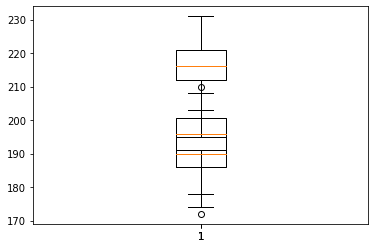

In [7]:
fig, ax = plt.subplots(1)

def plot_box(df):
    ax.boxplot(df['Flipper Length (mm)'])

penguins.groupby("Species").apply(plot_box)

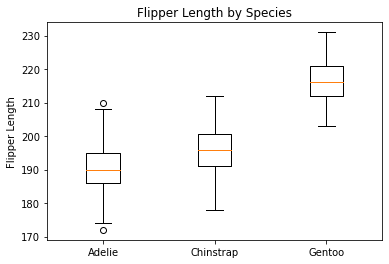

In [8]:
ad = penguins[penguins["Species"] == "Adelie"]["Flipper Length (mm)"] # 190
ch = penguins[penguins["Species"] == "Chinstrap"]["Flipper Length (mm)"] # 2
ge = penguins[penguins["Species"] == "Gentoo"]["Flipper Length (mm)"] # 3, tallest

fig, ax = plt.subplots(1)

bp = ax.boxplot([ad, ch, ge])
l = ax.set(ylabel = "Flipper Length", title = "Flipper Length by Species")
xl = plt.xticks([1, 2, 3], ["Adelie", "Chinstrap", "Gentoo"])

Though we ended up using the column combination of Island, Culmen Length, and Culmen Depth, as the output of the top 10 best column combinations showed, there were other options that we could have chosen. One of the columns that showed up repeatedly as a good predictors of species (that we did not end up using) was Flipper Length. In this boxplot graph, I examined how well Flipper Length can predict Species. As you can see in the results, knowing a penguin's flipper length can likely help in determining whether or not a penguin is of the Gentoo species. However, Flipper Length would not be that helpful in determining whether or not a pegnuin belongs to the Adelie or Chinstrap species.  

## Figure 3

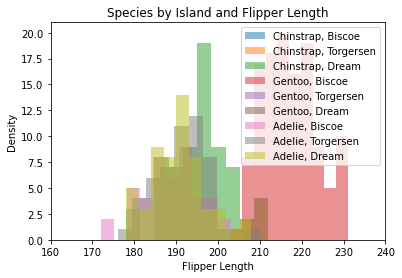

In [54]:
myData["Species"] = myData["Species"].str.split().str.get(0)

fig.set_figheight(15)
fig.set_figwidth(10)

fig, ax = plt.subplots(1)
species = set(myData['Species'])
location = set(myData['Island'])

ax.set(xlabel = 'Flipper Length', 
       ylabel = 'Density', 
       title = 'Species by Island and Flipper Length')

for s in species: 
    i = myData[myData['Species'] == s]
    for l in location:
        t = i[i['Island'] == l]
        ax.hist(t['Flipper Length (mm)'], label = str(s) + ', ' + str(l) , alpha = 0.5)
        ax.set_xlim([160,240])

ax.legend()

This graph shows us the correlation between the flipper length of each species on seperated by island. However this graph is really convoluted and we cannot see the data clearly.

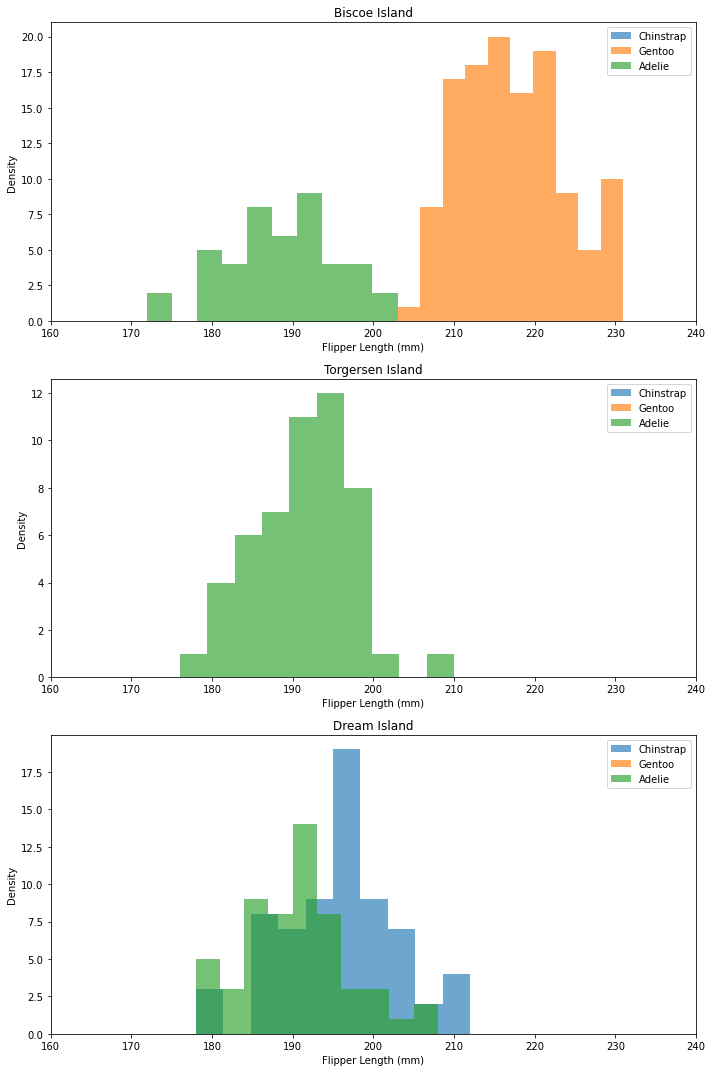

In [55]:
fig, ax = plt.subplots(3)
species = set(myData['Species'])
location = set(myData['Island'])

fig.set_figheight(15)
fig.set_figwidth(10)

count = 0
for l in location: 
   
    for s in species:
        i = myData[myData['Species'] == s]
        t = i[i['Island'] == l]
        ax[count].hist(t['Flipper Length (mm)'], label = str(s), alpha = 0.65)
    ax[count].legend()
    ax[count].set(xlabel = 'Flipper Length (mm)', ylabel = 'Density')
    ax[count].set_title(str(l) + ' Island')
    ax[count].set_xlim([160,240])
    count += 1
plt.tight_layout()

When we seperate the penguins by island, we are able to get a clearer view of what penguin is where. We can see that Adelie penguin is on all 3 islands. However the Chinstrap is only on Dream island, and the Gentoo is only on Biscoe. As the Adelie is on all 3 islands, we can see that its flipper length remains the relatively the same on each island. However, factors such as competition will cause changes the bell curve. There is more of a spread on Biscoe where the Adelie must compete with the larger Gentoo. We can also see that the Adelie and Chinstrap have are similar in size so the bell curve remains tight. These graphs can tell us that island may be able to help us predict the species. The flipper length will also be able to help differentiate the Gentoo from the other two but the Adelie and Chinstrap are relatively the same size. 

## Table Part 1

In [9]:
my_col = penguins[[ 'Species','Stage', 'Clutch Completion', 'Sex', 'Body Mass (g)']]
my_col.describe()

,Stage,Clutch Completion,Sex,Body Mass (g)
count,324.0,324.000000,324.000000,324.000000
mean,0.0,0.895062,0.503086,4213.966049
std,0.0,0.306948,0.500764,809.277529
min,0.0,0.000000,0.000000,2700.000000
25%,0.0,1.000000,0.000000,3550.000000
50%,0.0,1.000000,1.000000,4050.000000
75%,0.0,1.000000,1.000000,4800.000000
max,0.0,1.000000,1.000000,6300.000000


In this table, we are looking at the chart characteristics "Stage", "Clutch Completion", "Sex", "Body Mass(g)". From this chart we can sese that the column "Stage" would be a terrible factor to consider as it does not provide any data to help differentiate the species. The min and max are the same value. This means the only value in the column is the value 0, which represents the adult penguins. This column only shows that all the penguins are adults and does not help differentiate the species. For sex, it seems that the amount of male and female penguins is evenly distributed and that shows none of the penguin species are skewed a certain way. From this, we could conclude that sex would not be a good factor to include in our comparison. For clutch completion the data binarized and it does seem to be skewed toward. This might show that one species may have a high clutch completion. Therefore, compared to the other factors, this would be a stronger indicator of species. Last we have the body mass. The body mass might be the best indicator because it has the highest standard deviation. We can assume that this is due to the different species being different sizes. The body mass column is different from the other columns as the data is numerical and not just binarized. The more nunanced information will allow our models to be more specific. Overall, from this table we can infer that body mass and clutch completition will be strong indicators of species while stage and sex will not be as helpful. 

## Table Part 2

In [10]:
my_col.groupby('Species').aggregate([np.mean, np.std])

Stage      Clutch Completion                 Sex            \
           mean  std              mean       std      mean       std   
Species                                                                
Adelie        0  0.0          0.906475  0.292220  0.510791  0.501691   
Chinstrap     0  0.0          0.791045  0.409631  0.507463  0.503718   
Gentoo        0  0.0          0.940678  0.237234  0.491525  0.502060   

          Body Mass (g)              
                   mean         std  
Species                              
Adelie      3702.697842  460.167844  
Chinstrap   3729.850746  386.300411  
Gentoo      5091.101695  503.402158

The table above is similar to the previous table as we are looking at some statistics about the "Stage", "Clutch Completion", "Sex", "Body Mass(g)" columns. However here we have the data grouped by the species. The table above supports our some previous inferences. This table repeats that the stage shows no data at all as all penguins are at the same stage of life. The sex distribution between each species is very similar and lack any difference. We were also correct that body mass has more defined differences between each species. With the clutch completion, the data shows that this factor is stronger the stage and sex but not as strong for the body mass. 

# Finding the ideal combination using sklearn
We are now going to find the ideal combination of columns with the tools from our sklearn kit. 

In [11]:
#getting all possible combinations

names = list(penguins.columns)[1:]
combos = list(combinations(names, 3))

combos[1:6]

[('Island', 'Stage', 'Culmen Length (mm)'),
 ('Island', 'Stage', 'Culmen Depth (mm)'),
 ('Island', 'Stage', 'Flipper Length (mm)'),
 ('Island', 'Stage', 'Body Mass (g)'),
 ('Island', 'Stage', 'Sex')]

In [12]:
#using tree to select cols 
def check_column_score(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices
    """
    T = tree.DecisionTreeClassifier(max_depth = 5)
    return cross_val_score(T, x_train[cols], y_train, cv = 5).mean()  


def test_column_score(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices
    """
    cols = list(tupCol)
    T = tree.DecisionTreeClassifier(max_depth = 5)
    T.fit(x_train[cols], y_train)
    return T.score(x_test[cols], y_test)

In [13]:
# Splitting the data into test and training data

train, test = train_test_split(penguins, test_size = 0.3)
train.shape, test.shape

x_train = train.drop(['Species'], axis = 1)
y_train = train['Species'].values

x_test = test.drop(['Species'], axis = 1)
y_test = test['Species'].values

In [14]:
# Dict with cross value score of each combination 
D = {}

for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_score(cols)
    D[i] = x

In [15]:
# Sorts D and shows the top 10 column combinations 
L = list(D.items())
L.sort(key = lambda tup: tup[1], reverse = True)

#show 10 best scores
best = L[0:10]

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_score(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 15
('Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'), Score: 0.96464
Test score is: 0.9898
---- 18
('Island', 'Culmen Length (mm)', 'Sex'), Score: 0.9601
Test score is: 0.97959
---- 86
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'), Score: 0.95585
Test score is: 0.96939
---- 88
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)'), Score: 0.95585
Test score is: 0.91837
---- 85
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'), Score: 0.9514
Test score is: 0.96939
---- 89
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'), Score: 0.9513
Test score is: 0.95918
---- 93
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.94696
Test score is: 0.96939
---- 90
('Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)'), Score: 0.94686
Test score is: 0.91837
---- 29
('Island', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.94667
Test score is: 0.96939
---- 87
('Culmen Length (mm)', 'Culmen Depth

Looking at the above output, we believe that the column combination that has both the best cross evaluation score and the best test score is the combination at the 15th row of combos, which includes Island, Culmen Length, and Culmen Depth as its columns.

In [16]:
# Getting the data that includes just out best columns (which are located at combos[15])

X_train = train[list(combos[15])]
X_test = test[list(combos[15])]

Now, we are going to use a decision tree model to try and predict penguin species. 

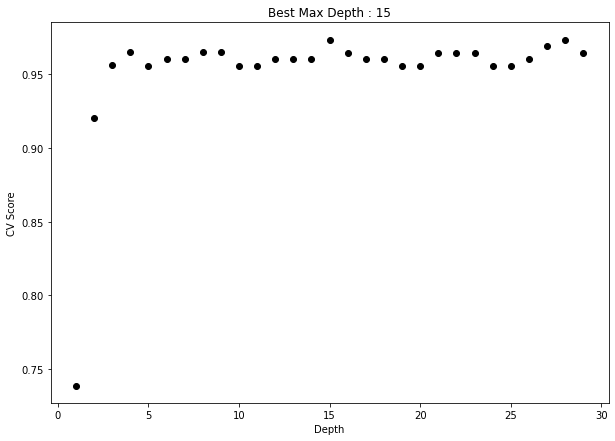

In [17]:
# Figuring out the best max depth for the decisiontree

fig, ax = plt.subplots(1, figsize = (10, 7))

best_score = 0

for d in range(1,30):
    T = tree.DecisionTreeClassifier(max_depth = d)
    cv_score = cross_val_score(T, X_train, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    
    if cv_score > best_score:
        best_depth = d
        best_score = cv_score

l = ax.set(title = "Best Max Depth : " + str(best_depth),
       xlabel = "Depth", 
       ylabel = "CV Score")

In [18]:
# The cross evaluation score gotten from the best max depth is:

best_score

0.9733201581027668

In [19]:
# Fitting the decision tree model

T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
T.score(X_test, y_test)

0.9897959183673469

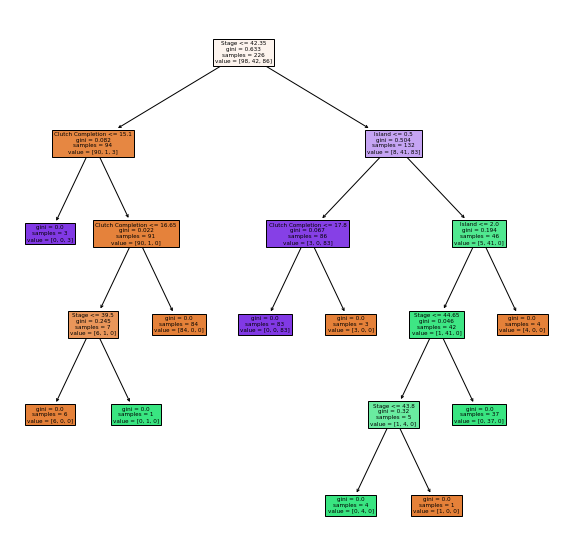

In [20]:
fig, ax = plt.subplots(1, figsize = (10, 10))
p = tree.plot_tree(T, 
                   filled = True, 
                   feature_names = penguins.drop(['Species'], axis = 1).columns)

Now, we are going to use a logistic regression model to try and predict penguin species. 

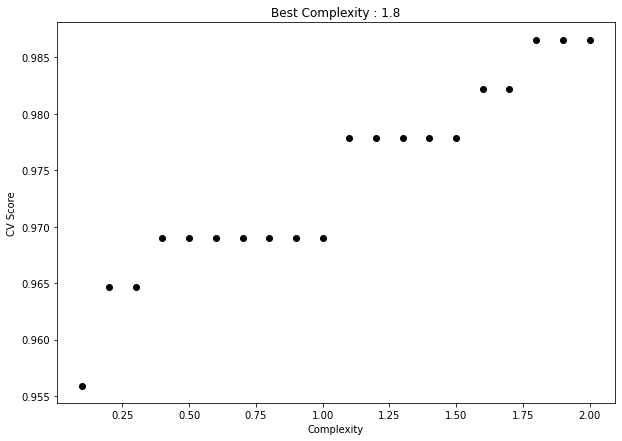

In [30]:
# Testing for best complexity for logistic regresssion

fig, ax = plt.subplots(1, figsize = (10, 7))
lr_best_score = 0

# Comp is short for complexity 
for comp in np.linspace(0.1, 2, 20):
    logreg = LogisticRegression(max_iter = 1000, C = comp)
    cv_score = cross_val_score(logreg, X_train, y_train, cv=10).mean()
    ax.scatter(comp, cv_score, color = "black")
    
    if cv_score > lr_best_score:
        best_comp = comp
        lr_best_score = cv_score
    
    
l = ax.set(title = "Best Complexity : " + str(best_comp),
       xlabel = "Complexity", 
       ylabel = "CV Score")

#lists to hold depths and complexities
t_depth = []
lr_c = []
mlp_depth = []

In [22]:
# The cross evaluation score with the best complexity is:

lr_best_score

0.9778656126482215

In [23]:
# Training the logistic regression model

lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9795918367346939

Now, we are going to use a multilayer perceptron classifier model to try and predict penguin species. 

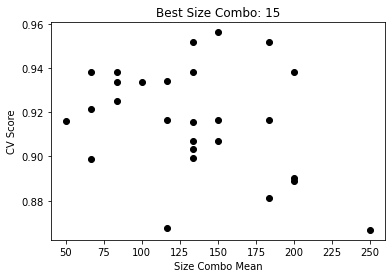

In [24]:
fig, ax = plt.subplots(1)

sizes = [50, 100, 250]
mlp_best_score = 0

for c1, c2, c3 in product(sizes, repeat =  3):
    
    clf = MLPClassifier(hidden_layer_sizes=(c1, c2, c3), max_iter=1000)
    cv_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    ax.scatter(mean([c1, c2, c3]), cv_score, color = "black")
    
    if cv_score > best_score:
        best_depth = (c1, c2, c3)
        mlp_best_score = cv_score
        
        
l = ax.set(title = "Best Size Combo: " + str(best_depth),
xlabel = "Size Combo Mean",
ylabel = "CV Score")

In [25]:
# The cross evaluation score gotten from the best size combo is:
mlp_best_score

0

In [31]:
# Train an MLPClassifier at best complexity, and evaluate the model on the test set

clf = MLPClassifier(hidden_layer_sizes = best_depth, max_iter=3000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9795918367346939

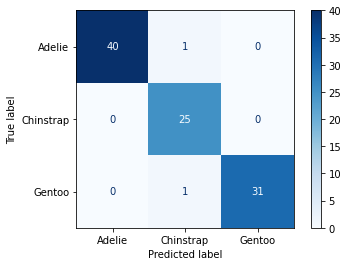

In [32]:
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
c = confusion_matrix(y_train, y_train_pred)

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues)

The confusion shows the model managed to be fairly accurate. The only penguin to be confused was the chinstrap as it taken for other penguins. This is likely due to the sizing of the culmen to be fairly similar

In [45]:
X_train = penguins[['Sex', 'Culmen Length (mm)', 'Culmen Depth (mm)']]
# Plot the decision regions
from sklearn import tree
def plot_regions(c, X, y):
    '''
    function used to plot regions 
    borrowed from the live lecture's code
    '''
        
    # for convenience, give names to the two 
    # columns of the data
    x0 = X['Culmen Length (mm)']
    x1 = X['Culmen Depth (mm)']
    
    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
    XX = xx.ravel()
    YY = yy.ravel()
    
    XY = np.c_[XX, YY]

    p = c.predict(XY)
    p = p.reshape(xx.shape)
    
    # create the plot
    fig, ax = plt.subplots(1)
    
    # use contour plot to visualize the predictions
    ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
    
    # plot the data
    ax.scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    
    ax.set(xlabel = "Culmen Length (mm)", 
           ylabel = "Culmen Depth (mm)")

    
    
# Fit the model with dropped Sex column, so that it can have 2 columns for plot regions

clf.fit(X_train.drop(['Sex'], axis=1), y_train)

# Separate the males and females, drop the sex column, predict the y's and plot
X_male = X_train.loc[X_train['Sex'] == 0]
X_male = X_male.drop(['Sex'], axis=1)
y_male = clf.predict(X_male)

X_female = X_train.loc[X_train['Sex'] == 1]
X_female = X_female.drop(['Sex'], axis=1)
y_female = clf.predict(X_female)


plot_regions(clf, X_male, y_male)

plot_regions(clf, X_female, y_female)

ValueError: Found input variables with inconsistent numbers of samples: [324, 226]

In [ ]:
'''
# Separate the males and females, drop the sex column, predict the y's and plot
X_male = X_train.loc[X_train['Sex'] == 1]
X_male = X_male.drop(['Sex'], axis=1)
y_male = clf.predict(X_male)

X_female = X_train.loc[X_train['Sex'] == 2]
X_female = X_female.drop(['Sex'], axis=1)
y_female = clf.predict(X_female)


plot_regions(clf, X_male, y_male)

plot_regions(clf, X_female, y_female)
'''

In [36]:
X_train

,Island,Culmen Length (mm),Culmen Depth (mm)
232,0,45.5,13.7
90,1,35.7,18.0
170,1,46.4,18.6
81,3,42.9,17.6
88,1,38.3,19.2
...,...,...,...
89,1,38.9,18.8
98,1,33.1,16.1
309,0,52.1,17.0
191,1,53.5,19.9


# Contribution Statement: 
Rashi, David, and Lauren each did one model and one figure. 
Lauren made figure 1. 
Rashi made figure 2.
David made figure 3.
David made the table. 
Rashi made the decision tree, combinations, and decision tree model.
David made the logistic regression model.
Lauren and Rashi made the MLP model. 
Lauren and David did the confusion matrix.
Lauren did the decision regions.
David helped with the decision regions.